<a href="https://colab.research.google.com/github/Sarayut-Aree/ML/blob/main/K_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

Data preparation

In [3]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
df.isna().sum() #missing values

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
df["bmi"].fillna(df['bmi'].mean(), inplace=True)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
print(df['gender'].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


In [7]:
df = df[df['gender'] != "Other"] #remove row "Other" from gender
print(df['gender'].value_counts())

Female    2994
Male      2115
Name: gender, dtype: int64


In [8]:
df.isna().sum() #missing values

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
Y = df.iloc[:,[11]]
Y

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
5105,0
5106,0
5107,0
5108,0


In [14]:
count =  Y['stroke'].value_counts()
count

0    4860
1     249
Name: stroke, dtype: int64

In [17]:
fig = px.bar(count)
fig.show()

In [13]:
X = df.iloc[:,1:11]
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked


In [19]:
df_copy = df

df_result = pd.get_dummies(df_copy, columns=['hypertension', 'heart_disease', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], prefix=['hypertension', 'heart_disease', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] )
df_result.rename(columns={"hypertension_0": "no_hypertension", "hypertension_1": "yes_hypertension", "heart_disease_0": "no_heart_disease", "heart_disease_1": "yes_heart_disease"}, inplace=True)

print(df_result.columns.tolist())
df_result

['id', 'age', 'avg_glucose_level', 'bmi', 'stroke', 'no_hypertension', 'yes_hypertension', 'no_heart_disease', 'yes_heart_disease', 'gender_Female', 'gender_Male', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


,id,age,avg_glucose_level,bmi,stroke,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,228.69,36.600000,1,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,202.21,28.893237,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,105.92,32.500000,1,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,171.23,34.400000,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,174.12,24.000000,1,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,83.75,28.893237,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
5106,44873,81.0,125.20,40.000000,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
5107,19723,35.0,82.99,30.600000,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
5108,37544,51.0,166.29,25.600000,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [20]:
df_result.corr()

,id,age,avg_glucose_level,bmi,stroke,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,1.000000,0.003677,0.000943,0.003153,0.006430,-0.003610,0.003610,0.001253,-0.001253,-0.001929,...,0.005471,0.023545,-0.019879,-0.013869,0.001219,-0.001219,-0.019126,0.007419,0.011567,0.001081
age,0.003677,1.000000,0.238323,0.325858,0.245239,-0.276367,0.276367,-0.263777,0.263777,0.027752,...,-0.078667,0.116678,0.327949,-0.634320,-0.014031,0.014031,-0.378366,0.237347,0.119207,0.073075
avg_glucose_level,0.000943,0.238323,1.000000,0.168910,0.131991,-0.174540,0.174540,-0.161907,0.161907,-0.054722,...,-0.014665,0.016451,0.062770,-0.102195,0.004783,-0.004783,-0.095035,0.067796,0.024011,0.017716
bmi,0.003153,0.325858,0.168910,1.000000,0.038912,-0.160147,0.160147,-0.038862,0.038862,0.025606,...,-0.028612,0.204055,0.070756,-0.442945,0.000288,-0.000288,-0.265094,0.104674,0.106107,0.085516
stroke,0.006430,0.245239,0.131991,0.038912,1.000000,-0.127891,0.127891,-0.134905,0.134905,-0.009081,...,-0.014885,0.011927,0.062150,-0.083888,-0.015415,0.015415,-0.055924,0.064683,-0.004163,0.008920
no_hypertension,-0.003610,-0.276367,-0.174540,-0.160147,-0.127891,1.000000,-1.000000,0.108292,-0.108292,0.021223,...,0.021612,0.005358,-0.115417,0.129535,-0.007980,0.007980,0.141551,-0.059022,-0.065018,-0.031213
yes_hypertension,0.003610,0.276367,0.174540,0.160147,0.127891,-1.000000,1.000000,-0.108292,0.108292,-0.021223,...,-0.021612,-0.005358,0.115417,-0.129535,0.007980,-0.007980,-0.141551,0.059022,0.065018,0.031213
no_heart_disease,0.001253,-0.263777,-0.161907,-0.038862,-0.134905,0.108292,-0.108292,1.000000,-1.000000,0.085685,...,0.015715,-0.000068,-0.086742,0.091654,0.003045,-0.003045,0.066765,-0.066938,0.021893,-0.044030
yes_heart_disease,-0.001253,0.263777,0.161907,0.038862,0.134905,-0.108292,0.108292,-1.000000,1.000000,-0.085685,...,-0.015715,0.000068,0.086742,-0.091654,-0.003045,0.003045,-0.066765,0.066938,-0.021893,0.044030
gender_Female,-0.001929,0.027752,-0.054722,0.025606,-0.009081,0.021223,-0.021223,0.085685,-0.085685,1.000000,...,-0.011486,0.032502,0.026045,-0.089226,-0.006105,0.006105,-0.059557,-0.043121,0.098952,-0.011408


In [21]:
corr_matrix = df_result.corr()
corr_matrix["stroke"].sort_values(ascending = False)

stroke                            1.000000
age                               0.245239
yes_heart_disease                 0.134905
avg_glucose_level                 0.131991
yes_hypertension                  0.127891
ever_married_Yes                  0.108299
smoking_status_formerly smoked    0.064683
work_type_Self-employed           0.062150
bmi                               0.038912
Residence_type_Urban              0.015415
work_type_Private                 0.011927
gender_Male                       0.009081
smoking_status_smokes             0.008920
id                                0.006430
work_type_Govt_job                0.002660
smoking_status_never smoked      -0.004163
gender_Female                    -0.009081
work_type_Never_worked           -0.014885
Residence_type_Rural             -0.015415
smoking_status_Unknown           -0.055924
work_type_children               -0.083888
ever_married_No                  -0.108299
no_hypertension                  -0.127891
no_heart_di

attributes which have main correlations with stroke (>0.10):

-age 

-avg glucose level 

-hypertension

-heart disease background

-ever married

In [33]:
X = df_result.drop(columns=['stroke', 'id'])
X

,age,avg_glucose_level,bmi,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.600000,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,202.21,28.893237,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,105.92,32.500000,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,171.23,34.400000,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,174.12,24.000000,0,1,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,83.75,28.893237,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,125.20,40.000000,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,82.99,30.600000,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,166.29,25.600000,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [49]:
Y = df.iloc[:,[11]]
Y

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
5105,0
5106,0
5107,0
5108,0


In [50]:
split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
for train_index, test_index in split.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
x = {'train': x_train, 'test': x_test}
y = {'train': y_train, 'test': y_test}

In [51]:
scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

scaling the numerical features of X_train

In [52]:
scaler.fit(x_train[['age', 'avg_glucose_level', 'bmi']])
x_train_scaled[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(x_train_scaled[['age', 'avg_glucose_level', 'bmi']])

x_train_scaled.describe()

,age,avg_glucose_level,bmi,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4.087000e+03,4.087000e+03,4.087000e+03,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,...,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,-2.022958e-16,2.486661e-16,-2.352127e-16,0.905310,0.094690,0.943235,0.056765,0.586494,0.413506,0.340103,...,0.003915,0.568632,0.162466,0.135796,0.497431,0.502569,0.302422,0.174945,0.371911,0.150722
std,1.000122e+00,1.000122e+00,1.000122e+00,0.292823,0.292823,0.231422,0.231422,0.492522,0.492522,0.473801,...,0.062454,0.495328,0.368923,0.342614,0.500055,0.500055,0.459363,0.379966,0.483374,0.357821
min,-1.907260e+00,-1.134397e+00,-2.402337e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.065280e-01,-6.366512e-01,-6.635186e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.688480e-02,-3.135136e-01,-6.236568e-02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,7.836150e-01,1.822176e-01,5.064672e-01,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.711198e+00,3.712554e+00,8.883825e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


scaling the numerical features of X_train

In [53]:
x_test_scaled[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(x_test_scaled[['age', 'avg_glucose_level', 'bmi']])

In [130]:
k_range = list(range(1, 131, 15))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_scaled, y_train, cv=10, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

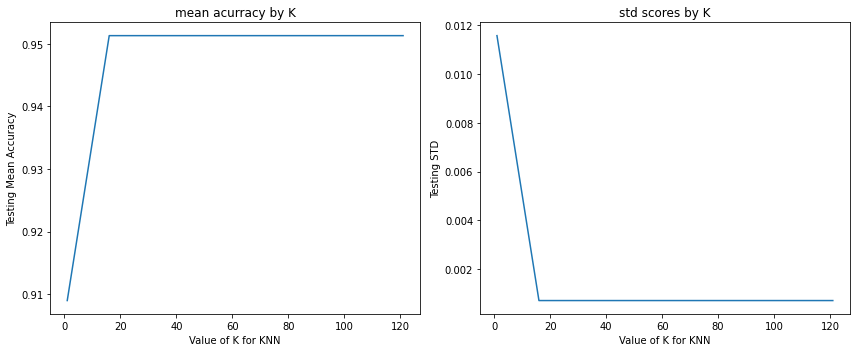

best mean acuarracy is: 0.9513093868354188
the best K's are:
       k_mean     k_std
16   0.951309  0.000709
31   0.951309  0.000709
46   0.951309  0.000709
61   0.951309  0.000709
76   0.951309  0.000709
91   0.951309  0.000709
106  0.951309  0.000709
121  0.951309  0.000709
in this case I will choose the smallest k between those K's for the model, to make it the as simple as we can.


In [131]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
((ax1, ax2)) = ax

ax1.plot(k_range, k_mean_scores)
ax1.set_title('mean acurracy by K')
ax1.set_xlabel('Value of K for KNN')
ax1.set_ylabel('Testing Mean Accuracy')

ax2.plot(k_range, k_std_scores)
ax2.set_title('std scores by K')
ax2.set_xlabel('Value of K for KNN')
ax2.set_ylabel('Testing STD')

plt.tight_layout()
plt.show()

max_score = max(k_mean_scores)
min_std = min(k_std_scores)
best_Ks = Ks[(Ks['k_mean']==max_score) & (Ks['k_std']==min_std)]
print("best mean acuarracy is: " +str(max_score))
print("the best K's are:")
print(best_Ks)
print("in this case I will choose the smallest k between those K's for the model, to make it the as simple as we can.")

In [132]:
min(best_Ks['k_mean'].index)

16

In [117]:
def cf_matrix_show(cf_matrix, beta = 4):

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
    recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    fb_score  = (1+beta**2)*precision*recall / ((beta**2)*precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\nFb Score={:0.3f}".format(
                    accuracy,precision,recall,f1_score, fb_score)

    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

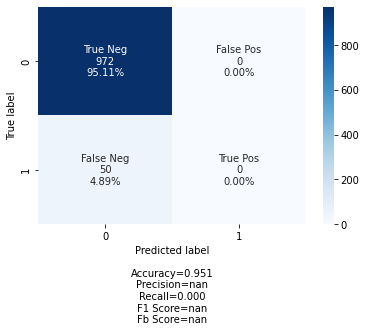

In [133]:
knn = KNeighborsClassifier(n_neighbors=min(best_Ks['k_mean'].index))
knn.fit(x_train_scaled, y_train)
y_predict = knn.predict(x_test_scaled)
cf_matrix_show(confusion_matrix(y_test, y_predict))

In [134]:
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_predict))
print('Classification Report: ')
print(classification_report(y_test, y_predict))

Confusion Matrix: 
[[972   0]
 [ 50   0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



Fix over sample 
not balance class

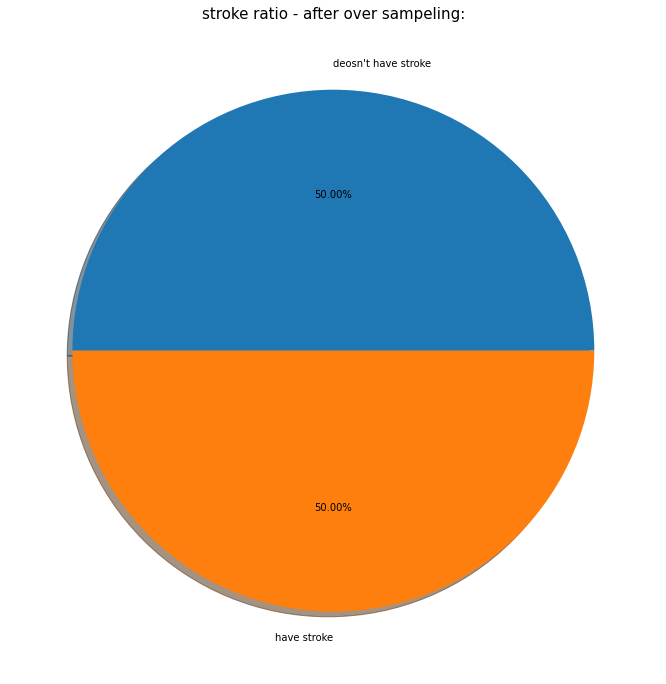

there are now equal number of cases with stroke and without: [3888, 3888]


In [119]:
oversample = SMOTE()
X, y = oversample.fit_resample(x_train_scaled, y_train)
upsampled_df = X.assign(Stroke = y)

fig, ax = plt.subplots(1,1, figsize = (12,12))
labels = ["deosn't have stroke", "have stroke"]
values = upsampled_df['Stroke'].value_counts().tolist()

ax.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax.set_title("stroke ratio - after over sampeling:", fontdict={'fontsize': 15})
plt.show()
print("there are now equal number of cases with stroke and without: " +str(values))

In [125]:
x_train_scaled_upsample = upsampled_df.drop(columns='Stroke')
y_train_upsamle = upsampled_df['Stroke']

In [126]:
x_train_scaled_upsample

,age,avg_glucose_level,bmi,no_hypertension,yes_hypertension,no_heart_disease,yes_heart_disease,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.209397,-0.821221,0.545251,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,-0.629845,-0.485884,-0.993183,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
2,-0.364822,0.302317,-0.773407,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,-0.232310,0.062342,0.493539,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,-1.292405,-0.527297,0.351331,1,0,1,0,0,1,1,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,0.644025,-0.722505,0.059549,1,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
7772,1.509424,1.789597,0.468649,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
7773,0.744438,2.066833,0.178785,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
7774,1.534516,-0.084895,-0.448128,0,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [127]:
y_train_upsamle

0       0
1       0
2       0
3       0
4       0
       ..
7771    1
7772    1
7773    1
7774    1
7775    1
Name: Stroke, Length: 7776, dtype: int64

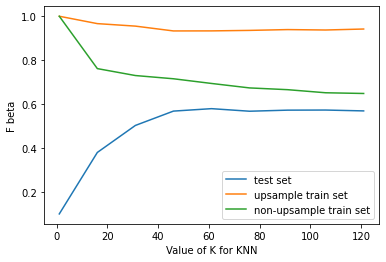

In [129]:
k_range = list(range(1, 131, 15))
beta=4

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled_upsample, y_train_upsamle)
    y_pred = knn.predict(x_test_scaled)
    scores.append(metrics.fbeta_score(y_test, y_pred, beta=beta))
plt.plot(k_range, scores)

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled_upsample, y_train_upsamle)
    y_pred = knn.predict(x_train_scaled_upsample)
    scores.append(metrics.fbeta_score(y_train_upsamle, y_pred, beta=beta))
plt.plot(k_range, scores)

scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled_upsample, y_train_upsamle)
    y_pred = knn.predict(x_train_scaled)
    scores.append(metrics.fbeta_score(y_train, y_pred, beta=beta))
    
plt.plot(k_range, scores)

plt.xlabel('Value of K for KNN')
plt.ylabel('F beta')
plt.legend(labels=['test set', 'upsample train set', 'non-upsample train set'])
plt.show()